# Demo - Exact GP

In [1]:
import sys
from pyprojroot import here
root = here(project_files=[".here"])
sys.path.append(str(here()))

# Jax settings
import jax
import jax.numpy as np
import objax

# Gaussian process settings
from jaxkern.data.regression import simple, near_square_wave
from jaxkern.gp.exact import ExactGP
from jaxkern.kernels.stationary import RBF
from jaxkern.gp.mean import LinearMean, ZeroMean
from jaxkern.gp.losses import negative_log_likelihood
from jaxkern.gp.utils import confidence_intervals

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Data

In [2]:
# X, y, Xtest, ytest = simple(30, 400, 0.0, 0.05)
input_cov = 0.0
output_cov = 0.08
X, y, Xtest, ytest = near_square_wave(60, 100, input_cov, output_cov)

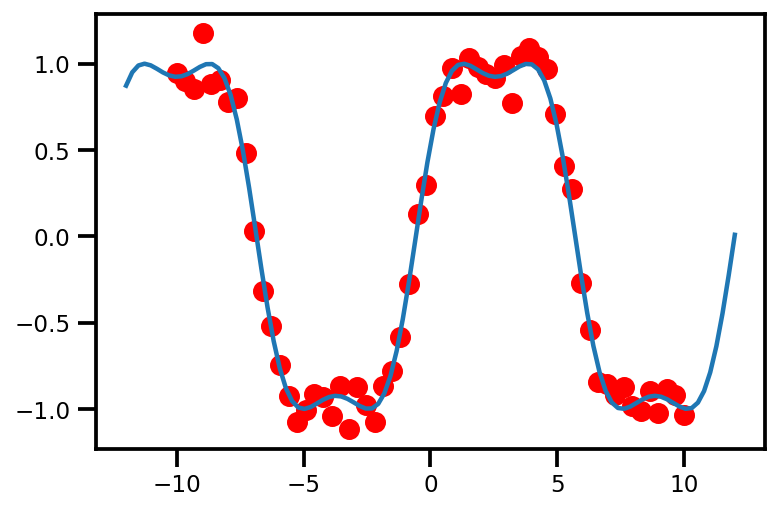

In [3]:
plt.scatter(X, y, color='red')
plt.plot(Xtest, ytest)

## Model

In [15]:
# initialize kernel
kernel = RBF(length_scale=np.exp(0.01), variance=np.exp(1.0))

# initialize mean function
# mean = LinearMean(input_dim=1, output_dim=1)
mean = ZeroMean(input_dim=1)

# initialize function
gp_model = ExactGP(mean=mean, kernel=kernel)

# inspect variables
for ikey, val in model.vars().items():
    print(ikey, val.value, jax.nn.softplus(val.value), type(val.value), val.value.shape)

<class 'jax.interpreters.xla.DeviceArray'>
<class 'jax.interpreters.xla.DeviceArray'> ()
(ExactGP).kernel(RBF).variance 0.0294042 0.7079574 <class 'jax.interpreters.xla.DeviceArray'> ()
(ExactGP).kernel(RBF).length_scale 1.5892296 1.7749476 <class 'jax.interpreters.xla.DeviceArray'> ()
(ExactGP).noise [-2.3666081] [0.08965635] <class 'jax.interpreters.xla.DeviceArray'> (1,)


In [20]:
from objax.optimizer import Adam
loss_f = jax.partial(negative_log_likelihood, model)

# create optimizer for variables
opt = Adam
opt = opt(model.vars())

# get gradient
gv = objax.GradValues(loss_f, gp_model.vars())

# get training loop
def train_op(X, y):

    g, v = gv(X, y)  # returns gradients, loss
    opt(lr, g)
    return v

In [22]:
g, v = gv(X, y)

In [23]:
g

[array(0., dtype=float32),
 array(0., dtype=float32),
 array([0.], dtype=float32)]

In [24]:
v

[DeviceArray(-24.171722, dtype=float32)]

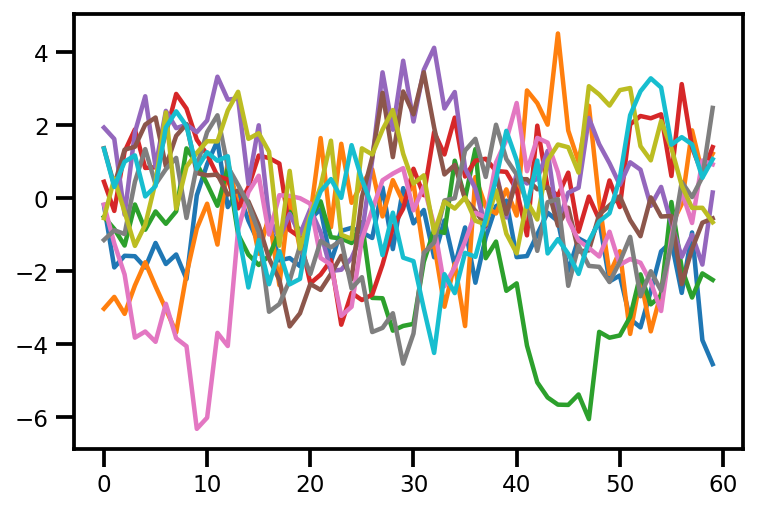

In [5]:
# generate random samples
dist = gp_model.forward(X)

seed = jax.random.PRNGKey(123)
y_samples = dist.sample((10,), seed=seed)

# plot
plt.plot(y_samples.T);

### Training

In [6]:
from jaxkern.gp.optimize import optimize_model

In [7]:
jitted = True
n_epochs = 1_000
lr = 0.01

model, losses = optimize_model(
    model=gp_model,
    loss_f=negative_log_likelihood,
    X=X, y=y,
    lr=lr,
    opt=objax.optimizer.Adam,
    n_epochs=n_epochs,
    jitted=jitted
)

100%|██████████| 1000/1000 [00:02<00:00, 335.00it/s, Loss=-24.17]


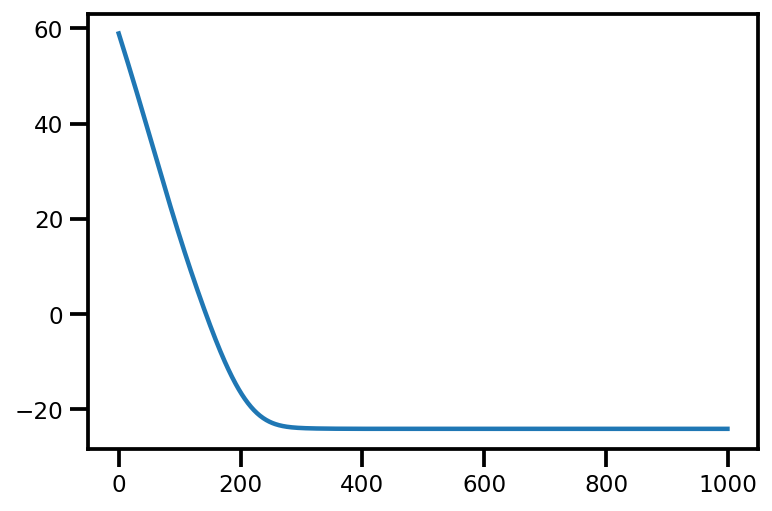

In [8]:
plt.plot(losses)

In [9]:
for ikey, val in model.vars().items():
    print(ikey, val.value, jax.nn.softplus(val.value), type(val.value), val.value.shape)

(ExactGP).kernel(RBF).variance 0.0294042 0.7079574 <class 'jax.interpreters.xla.DeviceArray'> ()
(ExactGP).kernel(RBF).length_scale 1.5892296 1.7749476 <class 'jax.interpreters.xla.DeviceArray'> ()
(ExactGP).noise [-2.3666081] [0.08965635] <class 'jax.interpreters.xla.DeviceArray'> (1,)


In [10]:
model.cache_factorizations(X, y)

mu, cov = model.predict_f(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

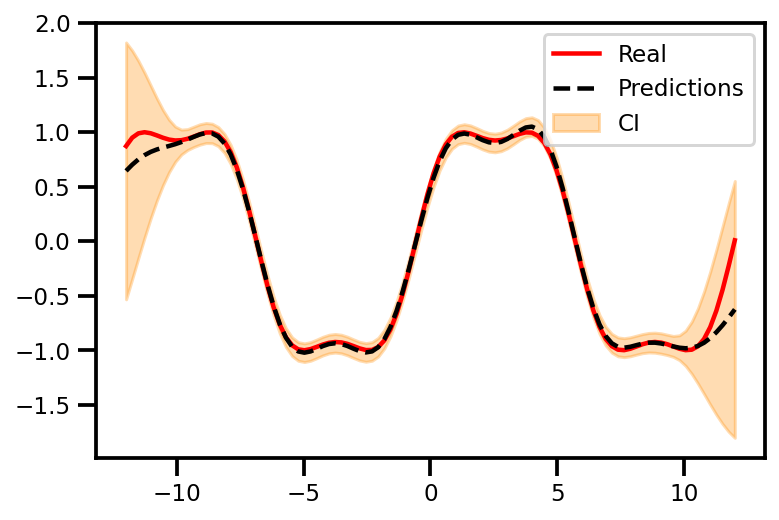

In [11]:
# plot
plt.plot(Xtest, ytest, label='Real', color='red')
plt.plot(Xtest, mu, linestyle="--", label='Predictions', color='black')
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

In [12]:
mu, cov = model.predict_y(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

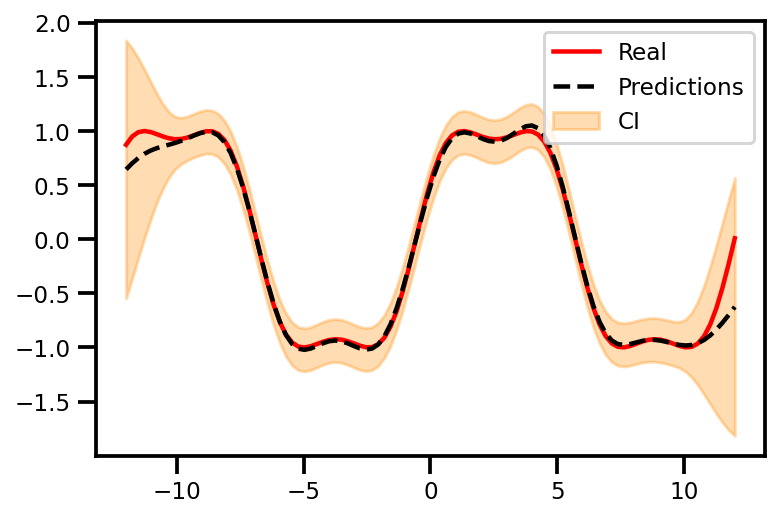

In [13]:
plt.plot(Xtest, ytest, label='Real', color='red')
plt.plot(Xtest, mu, linestyle="--", label='Predictions', color='black')
plt.fill_between(Xtest.squeeze(), lb, ub,label='CI', color='darkorange', alpha=0.3)

plt.legend()